In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [3]:
df_train= r"D:\tomato\train"
df_test= r"D:\tomato\val"

In [4]:
len(df_train)

15

In [6]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    df_train,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    df_test,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [7]:
class_names = dataset_train.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [8]:
for image_batch in dataset_train.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)
[5 0 0 2 3 6 6 4 6 4 0 3 4 0 1 5 7 5 2 8 3 6 8 3 2 4 0 7 8 6 1 5]


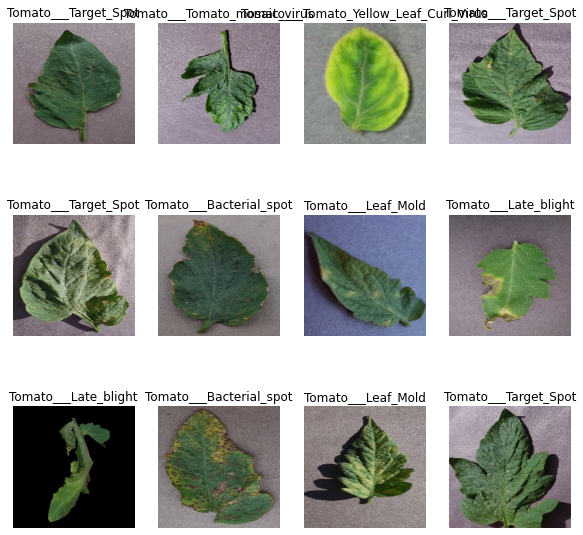

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset_train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
len(dataset_train)

313

In [11]:
def get_dataset_partitions_tf(df,train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split  + val_split) == 1
    ds_size = len(df)
    if shuffle:
        df= df.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds =df.take(train_size)    
    val_ds = df.skip(train_size).take(val_size)
    
    return train_ds, val_ds

In [12]:
train_ds, val_ds = get_dataset_partitions_tf(dataset_train)

In [13]:
len(train_ds)

250

In [14]:
len(val_ds)

62

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_test = dataset_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
data_scaling = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.5),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)    
    
])

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    data_scaling,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    dataset_train,
    batch_size=32,
    #steps_per_epoch=len(dataset_test)// batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
313/313 [==============================] - 551s 2s/step - loss: 1.7922 - accuracy: 0.3147 - val_loss: 1.2721 - val_accuracy: 0.5489
Epoch 2/20
313/313 [==============================] - 479s 2s/step - loss: 1.0646 - accuracy: 0.6145 - val_loss: 0.8527 - val_accuracy: 0.6895
Epoch 3/20
313/313 [==============================] - 467s 1s/step - loss: 0.7689 - accuracy: 0.7160 - val_loss: 0.7091 - val_accuracy: 0.7485
Epoch 4/20
313/313 [==============================] - 457s 1s/step - loss: 0.6143 - accuracy: 0.7794 - val_loss: 0.5115 - val_accuracy: 0.8201
Epoch 5/20
313/313 [==============================] - 456s 1s/step - loss: 0.5108 - accuracy: 0.8195 - val_loss: 0.4039 - val_accuracy: 0.8422
Epoch 6/20
313/313 [==============================] - 534s 2s/step - loss: 0.4057 - accuracy: 0.8561 - val_loss: 0.3005 - val_accuracy: 0.8936
Epoch 7/20
313/313 [==============================] - 474s 2s/step - loss: 0.3550 - accuracy: 0.8758 - val_loss: 0.2724 - val_accuracy: 0.9078

In [22]:
from tensorflow.keras.models import load_model
model.save('Tomatoleaf.h5')

In [23]:
from tensorflow.keras.models import load_model
model = load_model('Tomatoleaf.h5')

In [24]:
scores =model.evaluate(dataset_test)

32/32 [==============================] - 17s 360ms/step - loss: 0.5216 - accuracy: 0.8730


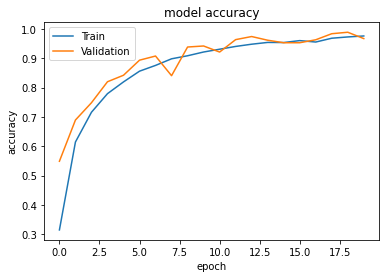

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

32/32 [==============================] - 19s 564ms/step


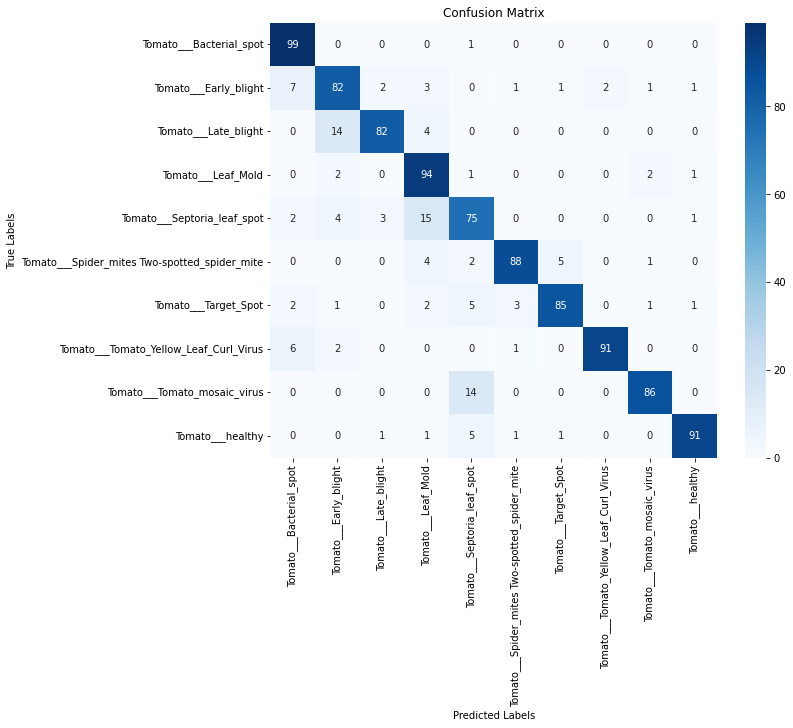

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_images = []
test_labels = []

for images_batch, labels_batch in dataset_test:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


first image to predict
actual label: Tomato___Bacterial_spot
1/1 [==============================] - 1s 1s/step
predicted label: Tomato___Bacterial_spot


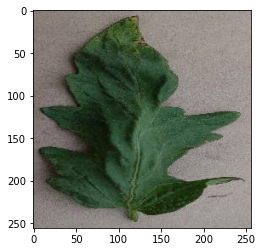

In [71]:
import numpy as np
for images_batch, labels_batch in dataset_test.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 41ms/step


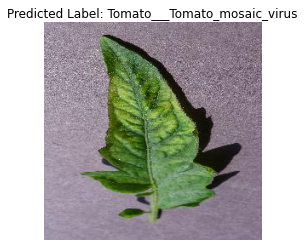

In [65]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

loc = r"D:\00c07a77-15e6-4815-92d4-8d1e1afb7f3c___PSU_CG 2052.JPG"
img = load_img(loc, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_label = class_names[np.argmax(prediction[0])]
plt.imshow(img)
plt.title("Predicted Label: " + predicted_label)
plt.axis("off")
plt.show()

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
predictions = model.predict(dataset_test)
predicted_labels = tf.argmax(predictions, axis=1)

true_labels = []
for _, labels_batch in dataset_test:
    true_labels.extend(labels_batch.numpy())
true_labels = np.array(true_labels)

precision = sklearn.metrics.precision_score(true_labels, predicted_labels, average='weighted')
recall = sklearn.metrics.recall_score(true_labels, predicted_labels, average='weighted')
f1score = sklearn.metrics.f1_score(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1score)

32/32 [==============================] - 14s 424ms/step
Precision: 0.10341343003190312
Recall: 0.104
F1-Score: 0.10341751785985255


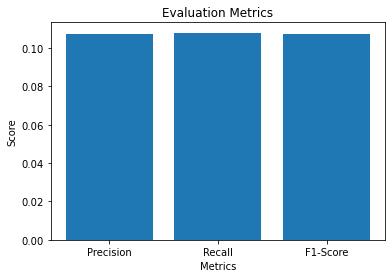

In [30]:
labels = ['Precision', 'Recall', 'F1-Score']
scores = [precision, recall, f1score]
plt.bar(labels, scores)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.show()

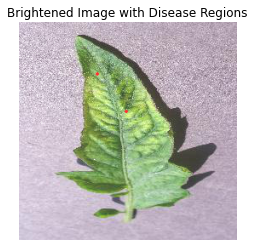

In [63]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

loc = r"D:\00c07a77-15e6-4815-92d4-8d1e1afb7f3c___PSU_CG 2052.JPG"
img = load_img(loc, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img)
preprocessed_image = data_scaling(img_array)
preprocessed_image = np.array(preprocessed_image, dtype=np.uint8)
gray_image = cv2.cvtColor(preprocessed_image, cv2.COLOR_RGB2GRAY)
_, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_with_regions = img_array.copy()

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_with_regions, (x, y), (x + w, y + h), (255, 0, 0), 2)

brightened_image = cv2.convertScaleAbs(image_with_regions, beta=50)  

plt.imshow(brightened_image)
plt.title("Brightened Image with Disease Regions")
plt.axis("off")
plt.show()